In [1]:
import pandas as pd
import numpy as np
from gaia_download import get_masses
import matplotlib.pyplot as plt
from download_isochrone import load_isochrone
from astropy.coordinates import SkyCoord, ICRS, Galactocentric
import astropy.units as u
from simbad_download import resolve_name

In [2]:
CLUSTER_NAME: str = 'Berkeley 36'
ROOT_PATH: str = f'data/{CLUSTER_NAME}'

# Mass

In [3]:
clustered = pd.read_csv(f'{ROOT_PATH}/{CLUSTER_NAME}_clustered.csv')
isochrone = load_isochrone(f'{ROOT_PATH}/{CLUSTER_NAME}_isochrone.dat', with_mass=True)

In [4]:
clustered = pd.merge(clustered, get_masses(clustered.source_id), on='source_id')

In [5]:
clustered_w_mass = clustered.dropna(subset=['mass_flame'])

In [6]:
clustered_w_mass_values = clustered_w_mass[['BP-RP', 'G_abs', 'mass_flame']].values

In [7]:
clustered_w_mass_values[:, :2].shape

(86, 2)

In [8]:
isochrone.shape

(315, 3)

In [9]:
BOUNDS = np.max(isochrone[:, [0, 1]], axis=0)-np.min(isochrone[:, [0, 1]], axis=0)

In [10]:
def find_closest(x):
    return isochrone[np.argmin(np.linalg.norm((x/BOUNDS-isochrone[:, [0, 1]]/BOUNDS), axis=1).flatten())][2]

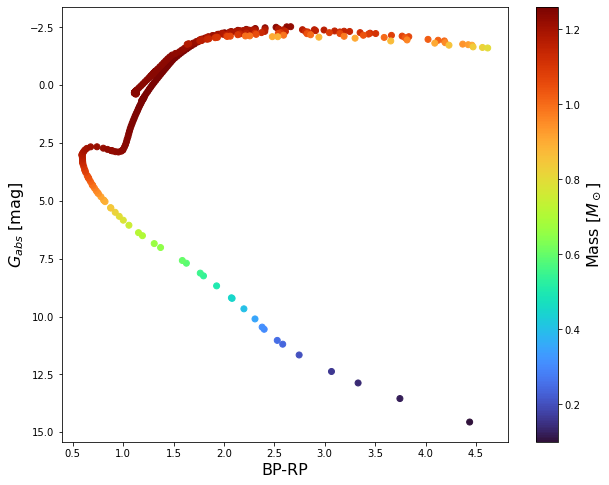

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(isochrone[:, 0], isochrone[:, 1], c=isochrone[:, 2], cmap='turbo')
cbar = plt.colorbar()
cbar.set_label('Mass [$M_\odot$]', fontsize=16)
plt.gca().invert_yaxis();
plt.gca().set_xlabel('BP-RP', fontsize=16)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16);

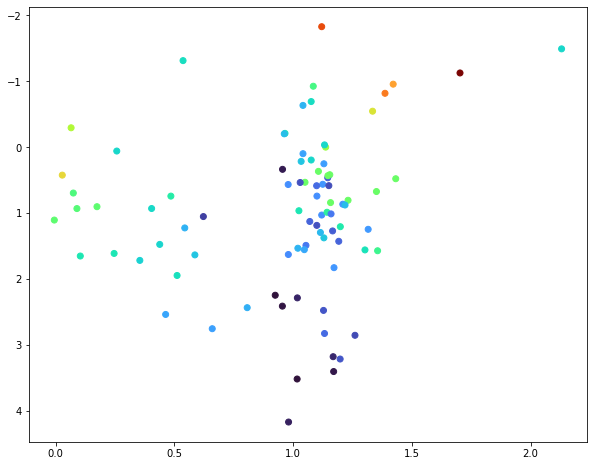

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(clustered_w_mass['BP-RP'], clustered_w_mass['G_abs'],
            c=clustered_w_mass['mass_flame'], cmap='turbo')
plt.gca().invert_yaxis();

In [13]:
clustered_without_mass = clustered[np.isnan(clustered['mass_flame'])]

In [14]:
clustered_without_mass['mass_flame'] = np.apply_along_axis(find_closest, axis=1, arr=clustered_without_mass[['BP-RP', 'G_abs']])

/tmp/ipykernel_18295/1298936366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_without_mass['mass_flame'] = np.apply_along_axis(find_closest, axis=1, arr=clustered_without_mass[['BP-RP', 'G_abs']])


In [15]:
clustered = pd.concat([clustered_w_mass, clustered_without_mass])

In [16]:
clustered = clustered[clustered.mass_flame<=np.max(isochrone[:, 2])]

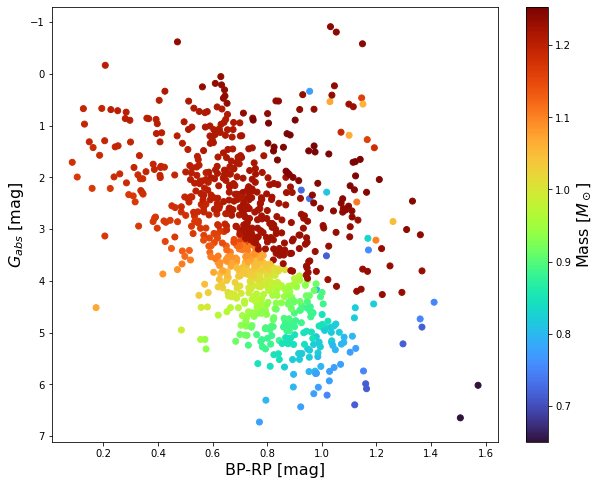

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(clustered['BP-RP'], clustered['G_abs'],
            c=clustered['mass_flame'], cmap='turbo')
plt.gca().invert_yaxis();
plt.gca().set_xlabel('BP-RP [mag]', fontsize=16)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Mass [$M_\odot$]', fontsize=16)

In [18]:
total_mass = np.sum(clustered['mass_flame']*clustered['occurences'])

In [19]:
total_mass

118.1645670936

# Density profile

In [20]:
galactic_coords = SkyCoord(ra=clustered.ra*u.deg,
                           dec=clustered.dec*u.deg,
                           distance=1/clustered.parallax*u.kpc,
                           frame=ICRS).galactic.cartesian

In [33]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_rv = resolve_name(CLUSTER_NAME)

In [34]:
gc_ra, gc_dec, gc_par, _, _, _ = resolve_name('Sgr A*')

In [35]:
galactic_cp = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                       distance=1/cp_par*u.kpc, frame=ICRS).galactic.cartesian

In [36]:
clustered['x'] = galactic_coords.x.value
clustered['y'] = galactic_coords.y.value
clustered['z'] = galactic_coords.z.value

In [37]:
cp_vec = np.array([galactic_cp.x.value, galactic_cp.y.value, galactic_cp.z.value])

In [38]:
SkyCoord(l=0*u.deg, b=0*u.deg, distance=8.3*u.kpc, frame='galactic').cartesian

<CartesianRepresentation (x, y, z) in kpc
    (8.3, 0., 0.)>

In [39]:
sgr_a_vec = np.array([8.3, 0., 0. ])

In [40]:
sgr_a_vec

array([8.3, 0. , 0. ])

In [41]:
unit_vector_1 = cp_vec / np.linalg.norm(cp_vec)

unit_vector_2 = sgr_a_vec/ np.linalg.norm(sgr_a_vec)

dot_product = np.dot(unit_vector_1, unit_vector_2)

angle = np.arccos(dot_product)

In [42]:
distance_from_galaxy = np.sqrt((1/cp_par)**2+8.3**2-2*(1/cp_par)*8.3*dot_product)

In [43]:
distance_from_galaxy

12.120076910396914

In [44]:
z_rad = max(galactic_coords.z)-min(galactic_coords.z)
x_rad = max(galactic_coords.x)-min(galactic_coords.x)
y_rad = max(galactic_coords.y)-min(galactic_coords.y)

In [45]:
z_rad, x_rad, y_rad

(<Quantity 0.28465868 kpc>,
 <Quantity 11.21349986 kpc>,
 <Quantity 12.21757978 kpc>)

In [46]:
radii = np.linspace(0, max(x_rad, y_rad, z_rad), 1000)
radius_mass = []

In [47]:
clustered.head()

,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,label,occurences,mass_flame,teff_esphs,teff_espucd,teff_msc1,teff_msc2,x,y,z
3,2838,1636148068921376768,Gaia DR3 3032928028376444416,3032928028376444416,1693575350,2016.0,108.982072,0.034243,-13.263043,0.037275,...,1,0.32,1.046944,NaN,<NA>,4370.6084,3395.0703,-2.294878,-2.504460,-0.041519
10,4331,1636148068921376768,Gaia DR3 3032946994949204352,3032946994949204352,1357554882,2016.0,109.142863,0.039396,-13.316465,0.040362,...,1,0.64,1.105464,NaN,<NA>,4274.2960,3698.9960,-2.729680,-2.991546,-0.041471
52,4846,1636148068921376768,Gaia DR3 3032951770952823936,3032951770952823936,1745421772,2016.0,109.063420,0.029154,-13.224305,0.030289,...,1,0.97,1.189796,NaN,<NA>,4102.6133,3563.9937,-3.276577,-3.576141,-0.051823
60,4901,1636148068921376768,Gaia DR3 3032951942751491072,3032951942751491072,341411541,2016.0,109.104846,0.027265,-13.199911,0.028231,...,1,0.87,1.159784,NaN,<NA>,4223.2344,3109.6210,-2.729577,-2.978839,-0.039851
67,4938,1636148068921376768,Gaia DR3 3032952114550193024,3032952114550193024,1668994956,2016.0,109.076583,0.065967,-13.198113,0.068928,...,1,0.42,0.756665,NaN,<NA>,4261.5610,3410.1445,-2.402595,-2.620673,-0.036527


In [48]:
def mass_for_radius(rad):
    in_sph = clustered[(clustered.x-galactic_cp.x)**2+
                        (clustered.y-galactic_cp.y)**2+
                        (clustered.z-galactic_cp.z)**2<=rad**2]
    return sum(in_sph.mass_flame*in_sph.occurences)

In [49]:
mass_for_radius(0.1)

8.330896962999999

In [50]:
for x_radius in radii:
    radius_mass.append(mass_for_radius(x_radius))

In [51]:
from scipy.optimize import fsolve

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [52]:
half_mass_radius = radii[np.argmin(np.abs(radius_mass-(total_mass/2.0)))]

In [53]:
half_mass_radius

<Quantity 1.07622324 kpc>

In [54]:
a = half_mass_radius/1.3

In [55]:
def plummer(r):
    return total_mass*(r**3/np.power(r**2+a**2, 3/2))

In [56]:
def tidal_radius(dist_gal, m):
    return dist_gal*np.power(m/(3e9), 1/3)

In [57]:
r_t = tidal_radius(distance_from_galaxy, total_mass)

In [58]:
r_c = 0.64*a.value

In [59]:
r_c

0.529832981539913

In [60]:
def surface_density_king_profile(k, r):
    return k*((1/np.sqrt(1+np.power(r.value/r_c, 2)))-
              (1/np.sqrt(1+np.power(r_t/r_c, 2))))**2

In [61]:
k = fsolve(lambda x: np.abs(surface_density_king_profile(x, max(x_rad, y_rad, z_rad))-1), [2.])

In [62]:
k

array([1.09954671])

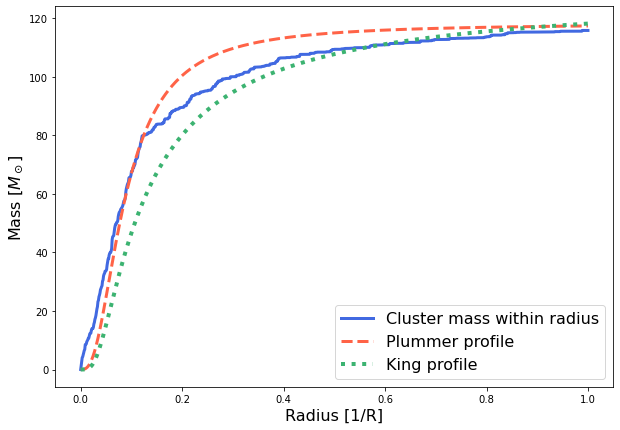

In [64]:
plt.figure(figsize=(10, 7))
plt.plot(radii/max(x_rad, y_rad, z_rad),
         radius_mass, color='royalblue', linewidth=3, label='Cluster mass within radius')
plt.plot(radii/max(x_rad, y_rad, z_rad),
         plummer(radii), color='tomato', linewidth=3, linestyle='--', label='Plummer profile')
plt.gca().set_xlabel('Radius [1/R]', fontsize=16)
plt.gca().set_ylabel('Mass [$M_\odot$]', fontsize=16)
plt.plot(radii/max(x_rad, y_rad, z_rad),
         (surface_density_king_profile(k, radii))*total_mass, color='mediumseagreen',
         linewidth=4, linestyle='dotted', label='King profile')

plt.legend(fontsize=16, loc='lower right')